In [1]:
!python3 -m pip install --upgrade pip
!pip install ipywidgets
!pip install gdown
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.5 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.3 MB/s eta 0:00:000:00:01


In [2]:
! pip install -q kaggle

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


unzip:  cannot find or open lumbar.zip, lumbar.zip.zip or lumbar.zip.ZIP.


In [5]:
import zipfile
import os


zip_output = "lumbar.zip"

with zipfile.ZipFile(zip_output, 'r') as zip_ref:
        zip_ref.extractall('.')

In [3]:
!kaggle competitions download -c lumbar

 99%|█████████████████████████████████████▌| 1.06G/1.07G [00:10<00:00, 75.8MB/s]
100%|███████████████████████████████████████| 1.07G/1.07G [00:10<00:00, 105MB/s]


In [6]:
import random
import numpy as np
import pandas as pd
import torch
from torch import nn
from torchvision import transforms
from matplotlib import pyplot as plt

import multiprocessing

def get_cpu_core_count():
    return multiprocessing.cpu_count()

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

   
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True
    
    return seed    



CONFIG = {
    'model_name' : 'eva02_base_patch14_224.mim_in22k',
    'img_size'   : 224,
    'EPOCHS'      : 50,
    'num_classes' : 2,
    'batch_train' : 64,
    'batch_test'  : 40,
    'num_fold'    : 7,
    'seed': 22,
    'device_str' :  "mps" if getattr(torch,'has_mps',False) else "cuda" if torch.cuda.is_available() else "cpu" ,
    'seed'       :  seed_everything(101),
   
}

CONFIG['device']  = torch.device(CONFIG['device_str'])
CONFIG['worker'] = get_cpu_core_count() if CONFIG['device_str']=="cuda"  else 0

CONFIG

{'model_name': 'eva02_base_patch14_224.mim_in22k',
 'img_size': 224,
 'EPOCHS': 50,
 'num_classes': 2,
 'batch_train': 64,
 'batch_test': 40,
 'num_fold': 7,
 'seed': 101,
 'device_str': 'cpu',
 'device': device(type='cpu'),
 'worker': 0}

In [7]:
import os
import pandas as pd

def create_label_dataframe(image_files):
    labels = []
    for file_path in image_files:
        # Assuming the folder containing the image file is the label
        label = os.path.basename(os.path.dirname(file_path))
        labels.append(label)

    data = {'File_Path': image_files, 'Label': labels}
    df = pd.DataFrame(data)
    return df

def find_image_files(folder_path):
    image_files = []
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif')):
                image_files.append(os.path.join(root, file))
    return image_files


folder_path = "BUU-LSPINE (Vertebral position)/train"  # Replace with the actual folder path
image_files = find_image_files(folder_path)

df = create_label_dataframe(image_files)

df['index'] = df['Label'].map({'AP':0,'LA':1})

df

,File_Path,Label,index
0,BUU-LSPINE (Vertebral position)/train/LA/193_L...,LA,1
1,BUU-LSPINE (Vertebral position)/train/LA/263_L...,LA,1
2,BUU-LSPINE (Vertebral position)/train/LA/369_L...,LA,1
3,BUU-LSPINE (Vertebral position)/train/LA/97_LA...,LA,1
4,BUU-LSPINE (Vertebral position)/train/LA/244_L...,LA,1
...,...,...,...
795,BUU-LSPINE (Vertebral position)/train/AP/379_A...,AP,0
796,BUU-LSPINE (Vertebral position)/train/AP/211_A...,AP,0
797,BUU-LSPINE (Vertebral position)/train/AP/37_AP...,AP,0
798,BUU-LSPINE (Vertebral position)/train/AP/139_A...,AP,0


In [8]:
import torch
import torchvision
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.transforms import ColorJitter
from PIL import Image
import random
import matplotlib.pyplot as plt



import torch
import numpy as np
import torch

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = torch.sqrt(1. - lam)
    cut_w = torch.round(W * cut_rat).type(torch.long)
    cut_h = torch.round(H * cut_rat).type(torch.long)

    # uniform
    cx = torch.randint(0, W, (1,)).item()
    cy = torch.randint(0, H, (1,)).item()

    bbx1 = torch.clamp(cx - cut_w // 2, 0, W)
    bby1 = torch.clamp(cy - cut_h // 2, 0, H)
    bbx2 = torch.clamp(cx + cut_w // 2, 0, W)
    bby2 = torch.clamp(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutmix(data, targets1, targets2, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]

    lam = torch.clamp(torch.distributions.beta.Beta(alpha, alpha).sample(), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, lam]
    return data, targets


class ImageDataset(Dataset):
    def __init__(self, data, label, transform=None):
        self.data = data
        self.label = label
        # Apply random crop with probability
      
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path, label = self.data[index], self.label[index]

        img = Image.open(img_path).convert('RGB')
       

        if self.transform is not None:
            img = self.transform(img)

        return img, torch.tensor(label,dtype=torch.int64)


 
class TestDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = self.data[index]

        img = Image.open(img_path).convert('RGB')
       

        if self.transform is not None:
            img = self.transform(img)

        return img

  # define data augmentation
train_transform = transforms.Compose([
   transforms.Resize((CONFIG['img_size'],CONFIG['img_size']), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=torch.tensor([0.4815, 0.4578, 0.4082]), std=torch.tensor([0.2686, 0.2613, 0.2758])),
])


  # define data augmentation
test_transform = transforms.Compose([
   transforms.Resize((CONFIG['img_size'],CONFIG['img_size']), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=torch.tensor([0.4815, 0.4578, 0.4082]), std=torch.tensor([0.2686, 0.2613, 0.2758])),
])

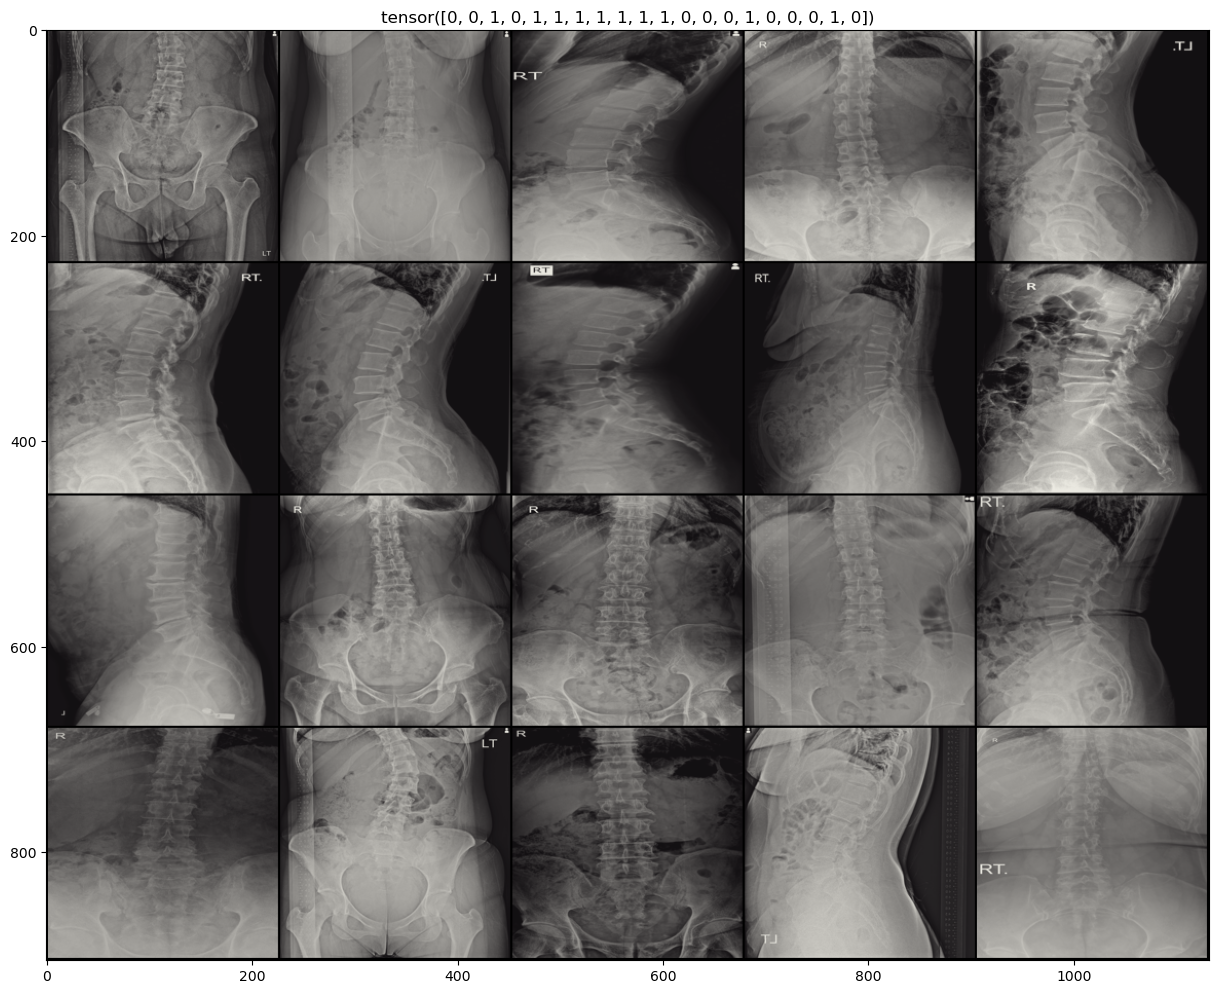

In [9]:

def Plot_dataloader(loader , batch_size = 20):

    invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                        std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                        std = [ 1., 1., 1. ]),
                                ])
    plt.figure(figsize=(15, 15))
    # iterate through data loader
    for images, labels in loader:
        # do something with the batch of images and labels
       
       # images,labels = cutmix(images, labels, labels, 1)

        images = invTrans(images[0:20])
        # Create a grid of images to display
        grid_image = torchvision.utils.make_grid(images, nrow=5)

        # Convert the grid image to a numpy array
        grid_image_np = grid_image.permute(1, 2, 0).numpy()

        # Display the grid image using matplotlib
        plt.imshow(grid_image_np)
        plt.title(labels[0:20]) 
        plt.show()
        break
    


train_dataset        =   ImageDataset( df['File_Path'].tolist() ,df['index'].tolist(), train_transform )
train_loader         =   DataLoader(train_dataset, batch_size=CONFIG['batch_train'], num_workers=CONFIG['worker'], shuffle=True)


Plot_dataloader( iter(train_loader) , batch_size = 20)



In [10]:
import torch
import torch.nn as nn

import timm

class TimmModel(nn.Module):
    def __init__(self):
        super(TimmModel, self).__init__()

        self.base    =timm.create_model(CONFIG['model_name'], pretrained=True)
        last_dim     =  list(self.base.parameters())[-2].shape[0]
       
        for param in self.base.parameters():
            param.requires_grad = False   

        self.final_layer = nn.Sequential(
               nn.Linear(last_dim , int(last_dim/2) ),
               nn.LayerNorm(int(last_dim/2)),
               nn.Linear(int(last_dim/2), CONFIG['num_classes']))

  
    def Unfreeze(self):
        for param in self.base.parameters():
            param.requires_grad = True   
        
        for param in self.final_layer.parameters():
            param.requires_grad = True   
        
        return   self


    def forward(self, x):
            x = self.base(x)
            x = self.final_layer(x)
            return x
    

model = TimmModel()

model 

/opt/conda/envs/pytorch/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1679586020379/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


TimmModel(
  (base): Eva(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (rope): RotaryEmbeddingCat()
    (blocks): ModuleList(
      (0-11): 12 x EvaBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): EvaAttention(
          (q_proj): Linear(in_features=768, out_features=768, bias=True)
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (norm): Identity()
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path1): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SwiGLU(
          (fc1_g): Linear(in_features=768, out

In [ ]:
import time
import torch.optim as optim

import torch
import psutil
import time
import subprocess

def get_gpu_usage():
    if torch.cuda.is_available() :
        output = subprocess.check_output(['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv,nounits,noheader'], encoding='utf-8')
        gpu_usage = [int(x) for x in output.strip().split('\n')]
    else :
          gpu_usage =[-1]
            
    return gpu_usage

def train(model, dataloader, criterion, optimizer, device, epoch, start_time_epoch):
    model.to(device)
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
       

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        

        if epoch >=5:
           data, targets = cutmix(X_batch, y_batch, y_batch, 1.0)
           optimizer.zero_grad()
           y_pred = model(data)
           loss = cutmix_criterion(nn.CrossEntropyLoss(), y_pred, targets)
        else :
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
        
        loss.backward()
      
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        #_, predicted = torch.max(y_pred.data, 1)
        total += y_batch.size(0)
        #correct += (predicted == y_batch).sum().item()

        # Get GPU usage
        gpu_usage = get_gpu_usage()

        # Get CPU usage
        cpu_percent = psutil.cpu_percent(interval=0.1)

        if torch.cuda.is_available():
            max_memory_allocated = torch.cuda.max_memory_allocated(device=torch.device("cuda"))
        else :
            max_memory_allocated = 0

        # Update progress bar
        print(f"\rTraining({epoch}) [{(batch_idx + 1) * len(X_batch)}/{len(dataloader.dataset)} "
              f"({100. * batch_idx / len(dataloader):.0f}%)] "
              f"Loss: {running_loss / (batch_idx + 1):.4f} "
              f"GPU Usage: {gpu_usage[0]}% "
              f"GPU Memory: {max_memory_allocated/(1000*1024**2):.4f} G "
              f"CPU Usage: {cpu_percent}%"
              f" Epoch Time: {time.time() - start_time_epoch:.2f} seconds ", end="")

    print("")
    train_accuracy = correct / total

    return running_loss / (batch_idx + 1), train_accuracy


def test(model, dataloader, device, best_accuracy,epoch,start_time_epoch, save_path):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0

   
    for batch_idx, (X_batch, y_batch) in enumerate(dataloader):
        
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)


        loss = criterion(y_pred, y_batch)
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(y_pred.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

        max_memory_allocated = torch.cuda.max_memory_allocated(device=torch.device("cuda")) 
        # Update progress bar
        print(f"\rTesting({epoch}) [{(batch_idx+1)*len(X_batch)}/{len(dataloader.dataset)} "
              f"({100. * batch_idx / len(dataloader):.0f}%)] "
              f"Test Loss: {running_loss/(batch_idx+1):.4f} "
              f"Test Accuracy: {correct/total:.4f} "
              f" Epoch Time: {time.time()-start_time_epoch:.2f} seconds ", end="")
            
              

    # Save model if accuracy is better than previous best
    test_accuracy = correct / total

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), save_path)
        print(f"\nModel saved with accuracy: {best_accuracy:.4f}", end="")
    else :
        print(f"\nModel not saved, best accuracy: {best_accuracy:.4f}", end="")    
   
   
    return running_loss/(batch_idx+1) , test_accuracy 


learning_rate  = 1e-5
criterion = nn.CrossEntropyLoss()
optimizer  = optim.Adam(model.parameters(), lr=learning_rate)



best_accuracy               = 0
Train_loss, Train_accuracy  = [], []
Test_Loss, Test_accuracy    = [], [],

for epoch in range(CONFIG['EPOCHS']):
    
    if epoch == 3 :
        model = model.Unfreeze()

    
    train_dataset        =   ImageDataset( df['File_Path'].tolist() ,df['index'].tolist(), train_transform )
    val_dataset          =  ImageDataset( df['File_Path'].tolist() ,df['index'].tolist(), train_transform )
    
    

    train_loader         =   DataLoader(train_dataset, batch_size=CONFIG['batch_train'], num_workers=CONFIG['worker'], shuffle=True)
    val_loader          =    DataLoader(train_dataset, batch_size=CONFIG['batch_train'], num_workers=CONFIG['worker'], shuffle=True)

    start_time_epoch = time.time()  # Calculate start time 
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, CONFIG['device'], epoch, start_time_epoch)
    test_loss ,test_accuracy = test(model, val_loader,CONFIG['device'], best_accuracy, epoch,start_time_epoch, f"best_epoch.pt") 
    
    Train_loss.append(train_loss)
    Train_accuracy.append(train_accuracy)
    Test_Loss.append(test_loss)
    Test_accuracy.append(test_accuracy)
    
    


Training(0) [320/800 (31%)] Loss: 0.8261 GPU Usage: -1% GPU Memory: 0.0000 G CPU Usage: 38.3% Epoch Time: 114.94 seconds 

In [ ]:
import os

if os.path.exists('best_epoch.pt'):
    # Load the saved checkpoint file
    checkpoint = torch.load('best_epoch.pt')
    model.load_state_dict(checkpoint)
    print("Model loaded")

In [ ]:

test_folder_path = "BUU-LSPINE (Vertebral position)/test"  # Replace with the actual folder path
test_image_files = find_image_files(test_folder_path)

test_image_files

In [ ]:

test_dataset =   TestDataset( test_image_files , test_transform)


In [ ]:
from tqdm import tqdm

model.to(CONFIG['device'])

results = []
   
model.eval()
with torch.no_grad():
    for X_batch in tqdm(test_dataset):
        X_batch= X_batch.unsqueeze(0).to(CONFIG['device'])
        y_pred = model(X_batch)
        _, predicted = torch.max(y_pred.data, 1)
        predicted = predicted.cpu().numpy()[0] +1
        results.append(predicted)


In [ ]:
df_results =pd.DataFrame({'Image':test_image_files,'Label':results})

df_results['Image'] = df_results['Image'].apply(lambda x : os.path.basename(os.path.basename(x)))
df_results['Label'] = df_results['Label'].map({1:'AP',2:'LA'})

df_results

In [ ]:
df_results.to_csv('position.csv',index=False)